## **오차제곱합(sum of squares for error, SSE)**

In [35]:
import numpy as np

In [36]:
def sum_squares_error(y, t):       # y는 신경망의 출력(추정 값), t는 정답 레이블
    return 0.5 * np.sum((y-t)**2)

In [37]:
# 정답은 '2'
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 1~10까지의 숫자 예측

# 예1 : '2'일 확률이 가장 높다고 추정함 (0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0] # 소프트맥스로 출력한 확률 값
sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [38]:
# 예2 : '7'일 확률이 가장 높다고 추정함 (0.6)
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t))

0.5975

오차제곱합 기준으로 오차가 작은 <예1>이 정답에 가까움을 알 수 있음

## **교차 엔트로피 오차(cross entropy error, CEE)**

In [39]:
def cross_entropy_error(y, t):
    delta = 1e-7 # np.log의 진수가 0이되면 계산할 수 없으므로 아주 작은 값(delta)가 필요 
    return -np.sum(t * np.log(y + delta)) # 정답이 아닐때는 t가 0이므로 결국에 정답일 때의 출력이 전체값을 정하게 됨

In [40]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [41]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

정답을 맞춘 첫번째 예시가 교차 엔트로피 오차값이 작은 것을 알 수 있음

## **미니배치(mini-batch) 학습**

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
mnist_path = '/content/drive/MyDrive/밑바닥부터시작하는딥러닝/deep-learning-from-scratch-master'

import sys
sys.path.append(mnist_path)
from dataset.mnist import load_mnist

In [44]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True) # 원-핫인코딩 되어 정답 위치의 원소만 1의 값을 가짐

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [45]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 훈련 데이터에서 무작위로 10장을 추출
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [46]:
np.random.choice(60000, 10)

array([57458, 33346, 56673, 31556, 40083,  3864, 49061, 33696, 16517,
       16984])

## **(배치용) 교차 엔트로피 오차 구현하기**

In [47]:
def cross_entropy_error(y, t):
    if y.ndim == 1: # 배치데이터가 아닌 경우
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size # 평균 교차 엔트로피 오차 공식

In [48]:
# 정답 레이블이 원-핫 인코딩이 아니라 숫자 레이블로 주어졌을 경우

def cross_entropy_error(y, t):
    if y.ndim == 1: 
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size # t가 0이 원소는 교차 엔트로피 오차가 0이므로, 그 계산은 무시

#y[np.arange(batch_size), t]는 각 데이터의 정답 레이블에 해당하는 신경망의 출력을 추출 ex) y[0,2], y[1,7], y[2,0] ~

## **왜 손실함수를 사용하는가?**

* 정확도 지표나 계단함수는 불연속적이다. 즉 매개변수의 미분이 대부분의 장소에서 0이다. 정확도가 개선된다 하더라도 ex)32%에서 32.0123%같은 연속적인 변화가 일어나지 않고 33%나 34%처럼 불연속적인 띄엄띄엄한 값으로 바뀌어버린다.

## **미분**

In [49]:
# 나쁜 구현 예
def numeriacal_diff(f, x):
    h = 1e-50
    return (f(x + h) - f(x)) / h

In [50]:
np.float32(1e-50)

0.0

* 문제점

    1. 반올림 오차문제를 일으킨다.
    2. 결국에는 h를 무한히 0으로 좁히지 못하여 접선이아닌 기울기에 해당한다.

In [51]:
def numerical_diff(f, x): # 수치 미분의 문제점을 개선한 구현
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

## **수치 미분의 예**

In [52]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

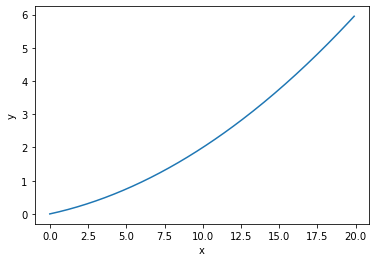

In [53]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1) # 0에서 20까지 0.1 간격의 배열 x를 만든다(20은 미포함)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y)
plt.show()

In [54]:
numerical_diff(function_1, 5)

0.1999999999990898

In [55]:
numerical_diff(function_1, 10)

0.2999999999986347

실제 해석적 미분의 해와 거의 같음을 알 수 있음

## **편미분** 

In [56]:
def function_2(x):
    return x[0]**2 + x[1]**2 # 또는 return np.sum(x**2)

## **기울기(gradient)**

In [57]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성

    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

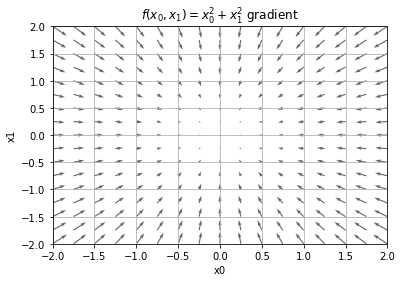

In [66]:
from mpl_toolkits.mplot3d import Axes3D


def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad


def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)


def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y
     
if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]) )
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid()
    plt.draw()
    plt.title('$f(x_0,x_1)=x_0^2 + x_1^2$ gradient')
    plt.show()

**기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향**

## **경사법(경사 하강법)**

In [68]:
def gradient_descent(f, init_x, lr=0.01, step_num=100): # f는 최적화하려는 함수, init_x는 초깃값, lr은 학습률(learning rate), step_num은 경사법에 따른 반복 횟수
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad # 경사법 수식
    return x

이 함수를 통해 극솟값을 구할 수 있고, 잘하면 최솟값을 구할 수도 있음

In [69]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

실제 최솟값이 (0, 0)이므로 경사법으로 거의 정확한 결과를 얻음

In [70]:
# 학습률에 대한 두가지 실험

# 학습률이 너무 큰 예 : lr=10.0
gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

In [71]:
# 학습률이 너무 작은 예 : lr=1e-10
gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

array([ 2.34235971e+12, -3.96091057e+12])

* 학습률이 너무 큰 예 : 발산해버림
* 학습률이 너무 작은 예 : 갱신되지 않은 채 끝나버림

따라서 학습률을 적절히 설정하는 일이 중요함을 알 수 있음

## **신경망에서의 기울기**

In [72]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [73]:
net = simpleNet()
print(net.W)

[[ 1.16603165  0.75107585  0.73433659]
 [-0.78316383 -0.97731875 -0.23348757]]


In [75]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[-0.00522846 -0.42894136  0.23046314]


In [76]:
np.argmax(p) # 최댓값의 인덱스

2

In [77]:
t = np.array([0, 0, 1]) # 정답 레이블
net.loss(x, t)

0.8360272836551538

In [78]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.20545157  0.13449102 -0.33994258]
 [ 0.30817735  0.20173653 -0.50991387]]


In [80]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.20545157  0.13449102 -0.33994258]
 [ 0.30817735  0.20173653 -0.50991387]]


* $w_{11}$을 $h$ 만큼 늘리면 손실 함수의 값은 $0.2h$만큼 증가 -> 음의 방향으로 갱신해야 함

* $w_{23}$을 $h$만큼 늘리면 손실 함수의 값은 $0.5h$만큼 감소 -> 양의 방향으로 갱신해야 함

* 한번에 갱신되는 양에는 $w_{23}$이 $w_{11}$보다 크게 기여함

## **2층 신경망 클래스 구현하기**

In [99]:
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    # def numerical_gradient(self, x, t):
    #     loss_W = lambda W: self.loss(x, t)

    #     grads = {}
    #     grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    #     grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    #     grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    #     grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    #     return grads

    def gradient(self, x, t): # 차후 설명할 오차역전파 방법(학습 시간절약)
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [100]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print('net.params["W1"].shape : ', net.params['W1'].shape)
print('net.params["b1"].shape : ', net.params['b1'].shape)
print('net.params["W2"].shape : ', net.params['W2'].shape)
print('net.params["b2"].shape : ', net.params['b2'].shape)


net.params["W1"].shape :  (784, 100)
net.params["b1"].shape :  (100,)
net.params["W2"].shape :  (100, 10)
net.params["b2"].shape :  (10,)


In [101]:
x = np.random.rand(100, 784) # 더미 입력 데이터(100장 분량)
y = net.predict(x)
t = np.random.rand(100, 10) # 더미 정답 레이블(100장 분량)

grads = net.gradient(x, t) # 기울기 계산
print('grads["W1"].shape : ', grads['W1'].shape)
print('grads["b1"].shape : ', grads['b1'].shape)
print('grads["W2"].shape : ', grads['W2'].shape)
print('grads["b2"].shape : ', grads['b2'].shape)

grads["W1"].shape :  (784, 100)
grads["b1"].shape :  (100,)
grads["W2"].shape :  (100, 10)
grads["b2"].shape :  (10,)


## **미니배치 학습 구현하기**

In [102]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 하이퍼 파라미터
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    # grad = network.gradient(x_batch, t_batch) # 오차역전파법을 사용한 성능 개선판, 차후 설명

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

그래프를 확인해보면, 확률적 경사 하강법(stochastic gradient descent)을 통해 데이터를 반복해서 학습함으로써 최적 가중치 매개변수로 서서히 다가감을 알 수 있음

## **시험 데이터로 평가하기**

In [103]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = [] # 훈련 평가 지표
test_acc_list = [] # 테스트 평가 지표

# 하이퍼 파라미터
iters_num = 10000 # 반복 횟수
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

# 1에폭당 반복 수 (1에폭(epoch)은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수)
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch) # 오차역전파법을 사용한 성능 개선판, 차후 설명

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc : " + str(train_acc) + "," + str(test_acc))

train acc, test acc : 0.09915,0.1009
train acc, test acc : 0.78595,0.7935
train acc, test acc : 0.8780166666666667,0.8823
train acc, test acc : 0.8983666666666666,0.9024
train acc, test acc : 0.9073833333333333,0.9081
train acc, test acc : 0.9141166666666667,0.915
train acc, test acc : 0.9178333333333333,0.9197
train acc, test acc : 0.9227666666666666,0.9249
train acc, test acc : 0.92635,0.9274
train acc, test acc : 0.9304,0.9305
train acc, test acc : 0.9334333333333333,0.9345
train acc, test acc : 0.9358166666666666,0.9365
train acc, test acc : 0.9383666666666667,0.9389
train acc, test acc : 0.9401333333333334,0.941
train acc, test acc : 0.9432333333333334,0.9422
train acc, test acc : 0.9449166666666666,0.9433
train acc, test acc : 0.9459666666666666,0.945


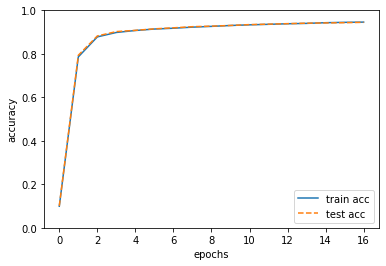

In [104]:
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

* 에폭이 진행될수록(학습이 진행될수록) 훈련 데이터와 시험 데이터를 사용하고 평가한 정확도가 모두 좋아지고 있으며, 두 정확도에는 차이가 없음을 알 수 있음

* 다시 말해 이번 학습에서 오버피팅이 일어나지 않았음
(만약 오버피팅이 일어난다면 시험 데이터에 대한 정확도가 점점 떨어질 것)

# **정리**

* **기계학습에서 사용하는 데이터셋은 훈련 데이터와 시험 데이터로 나눠 사용한다.**
* **훈련 데이터로 학습한 모델의 범용 능력을 시험 데이터로 평가한다.**
* **신경망 학습은 손실 함수를 지표로, 손실 함수의 값이 작아지는 방향으로 가중치 매개변수를 갱신한다.**
* **가중치 매개변수를 갱신할 때는 가중치 매개변수의 기울기를 이용하고, 기울어진 방향으로 가중치의 값을 갱신하는 작업을 반복한다.**
* **아주 작은 값을 주었을 때의 차분으로 미분하는 것을 수치 미분이라고 한다.**
* **수치 미분을 이용해 가중치 매개변수의 기울기를 구할 수 있다.**
* **수치 미분을 이용한 계산에는 시간이 걸리지만, 그 구현은 간단하다. 한편, 다음 장에서 구현하는(다소 복잡한) 오차 역전파법은 기울기를 고속으로 구할 수 있다.**